# Contact analysis
### by: Edward Mendez-Otalvaro
<p>This script calculates the number of contact within a range of two selections. The final output is the frequency of contacts and the atoms and residues interacting during the simulation</p>

In [52]:
from tqdm import tqdm

In [4]:
!pip install --upgrade MDAnalysis MDAnalysisTests

     |████████████████████████████████| 3.4 MB 19.3 MB/s 
     |████████████████████████████████| 52.3 MB 48 kB/s 
     |████████████████████████████████| 2.3 MB 39.4 MB/s 
     |████████████████████████████████| 2.0 MB 32.9 MB/s 
     |████████████████████████████████| 334 kB 76.8 MB/s 
     |████████████████████████████████| 381 kB 61.5 MB/s 
  Created wheel for MDAnalysis: filename=MDAnalysis-2.0.0-cp37-cp37m-linux_x86_64.whl size=4486085 sha256=08c3db8dd0aefe2aacc264de14e002ff88f4f22ffe991d1ec7d2a385a49d431b
  Stored in directory: /root/.cache/pip/wheels/e9/38/a1/b52afa08dcd5300512ec92a8878f48c3460f92a72745e057c1
  Created wheel for MDAnalysisTests: filename=MDAnalysisTests-2.0.0-py2.py3-none-any.whl size=52644220 sha256=742c109b8899c163bcd1bca32c96991fe5f0a30d2a436792fed5fd820377c66a
  Stored in directory: /root/.cache/pip/wheels/51/ee/af/4f397b2a5f71092af96642c61f80ed5e2553c4729400e6e65e
Successfully built MDAnalysis MDAnalysisTests


In [5]:
!pip install nglview

     |████████████████████████████████| 5.7 MB 27.6 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for nglview: filename=nglview-3.0.3-py3-none-any.whl size=8057549 sha256=728ca825b80ae242307f329f1a5db9c39041203d23e75403b81c7e404c29b3ea
  Stored in directory: /root/.cache/pip/wheels/01/0c/49/c6f79d8edba8fe89752bf20de2d99040bfa57db0548975c5d5
Successfully built nglview


In [1]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
from google.colab import output
output.enable_custom_widget_manager()

In [6]:
import MDAnalysis as mda
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets
import nglview as nv
import numpy as np
import pandas as pd
from MDAnalysis.tests.datafiles import PSF, DCD
from MDAnalysis.analysis import distances

In [ ]:
#from google.colab import output
#output.disable_custom_widget_manager()

In [7]:
u = mda.Universe('/content/gdrive/MyDrive/rclone-test-folder/CtrlNeg/md_0_10.tpr', '/content/gdrive/MyDrive/rclone-test-folder/CtrlNeg/md_0_10.xtc')

In [8]:
from MDAnalysis import transformations
##Making trajectory whole again and center protein+ligand complex
##Center around complex
ag = u.atoms

complex_MD=u.select_atoms("protein")+u.select_atoms("resname MOL")
# we will use mass as weights for the center calculation
workflow = (transformations.unwrap(ag),
                   transformations.center_in_box(complex_MD, center='mass'),
                   transformations.wrap(ag, compound='fragments'))
u.trajectory.add_transformations(*workflow)

In [26]:
# Selections of interest. In this example protein_1 an ligand_2
#u = mda.Universe(PSF, DCD)
#protein_1 = u.select_atoms('resnum 201-212 and name CA')
#ligand_2 = u.select_atoms('resnum 13-23 and name CA')
protein_1 = u.select_atoms('resid 605 and (name NZ) or (resid 692 and (name OE1 OE2)) or (resid 589 and (name CG CB)) or (resid 723 and (name CD CG)) or (resid 648 and (name OG1))')
ligand_2 =u.select_atoms('resname MOL')

complex_interaction=protein_1+ligand_2
#nv.show_mdanalysis(complex_interaction,gui=True)

In [28]:
##Building contact frequency histogram across simulation

def build_histogram(lines):
    """
    """
    histogram = {}

    for frame in lines:
        
        for i in frame:
            histogram[i]=histogram.get(i,0)+1
    return(histogram)   

    for key in sorted(histogram):
       print(
            "{}: {}".format(key, histogram[key])   #$
        )

In [53]:
# to iterate over frames and obtain total contacts:
def calculate_contactos(entity_1,entity_2,trayectoria):
  """
  """
  from MDAnalysis.analysis import distances
  distances_in_traj = []
  pairs_in_traj=[]

  for ts in tqdm(trayectoria.trajectory[0:50000:100]): 
    
    res_pairs = distances.capped_distance(entity_1.positions, entity_2.positions,
                                       8, box=u.dimensions, # cutoff  4.0 angstrom
                                       return_distances=False)
  left, right = res_pairs.T  # transpose and split out into variables

  entity_1_resnames = entity_1[left].resnames
  entity_2_resnames = entity_2[right].resnames
  entity_1_resids = entity_1[left].resids
  entity_2_resids = entity_2[right].resids
  entity_1_atnames = entity_1[left].names
  entity_2_atnames = entity_2[right].names

  qualnames = [(f"{n1}{i1};{an1}", f"{n2}{i2};{an2}") for n1, i1, an1, n2, i2, an2 in zip(entity_1_resnames, entity_1_resids,entity_1_atnames,
                                                                                         entity_2_resnames, entity_2_resids,entity_2_atnames)]
  unique_pairs = list(set(qualnames))
  
  
  distances_in_traj.append(res_pairs)
  pairs_in_traj.append(unique_pairs)

  return pairs_in_traj, distances_in_traj
  
########################

In [54]:
distancias,frequencias=calculate_contactos(protein_1,ligand_2,u)


100%|██████████| 51/51 [34:07<00:00, 40.15s/it]


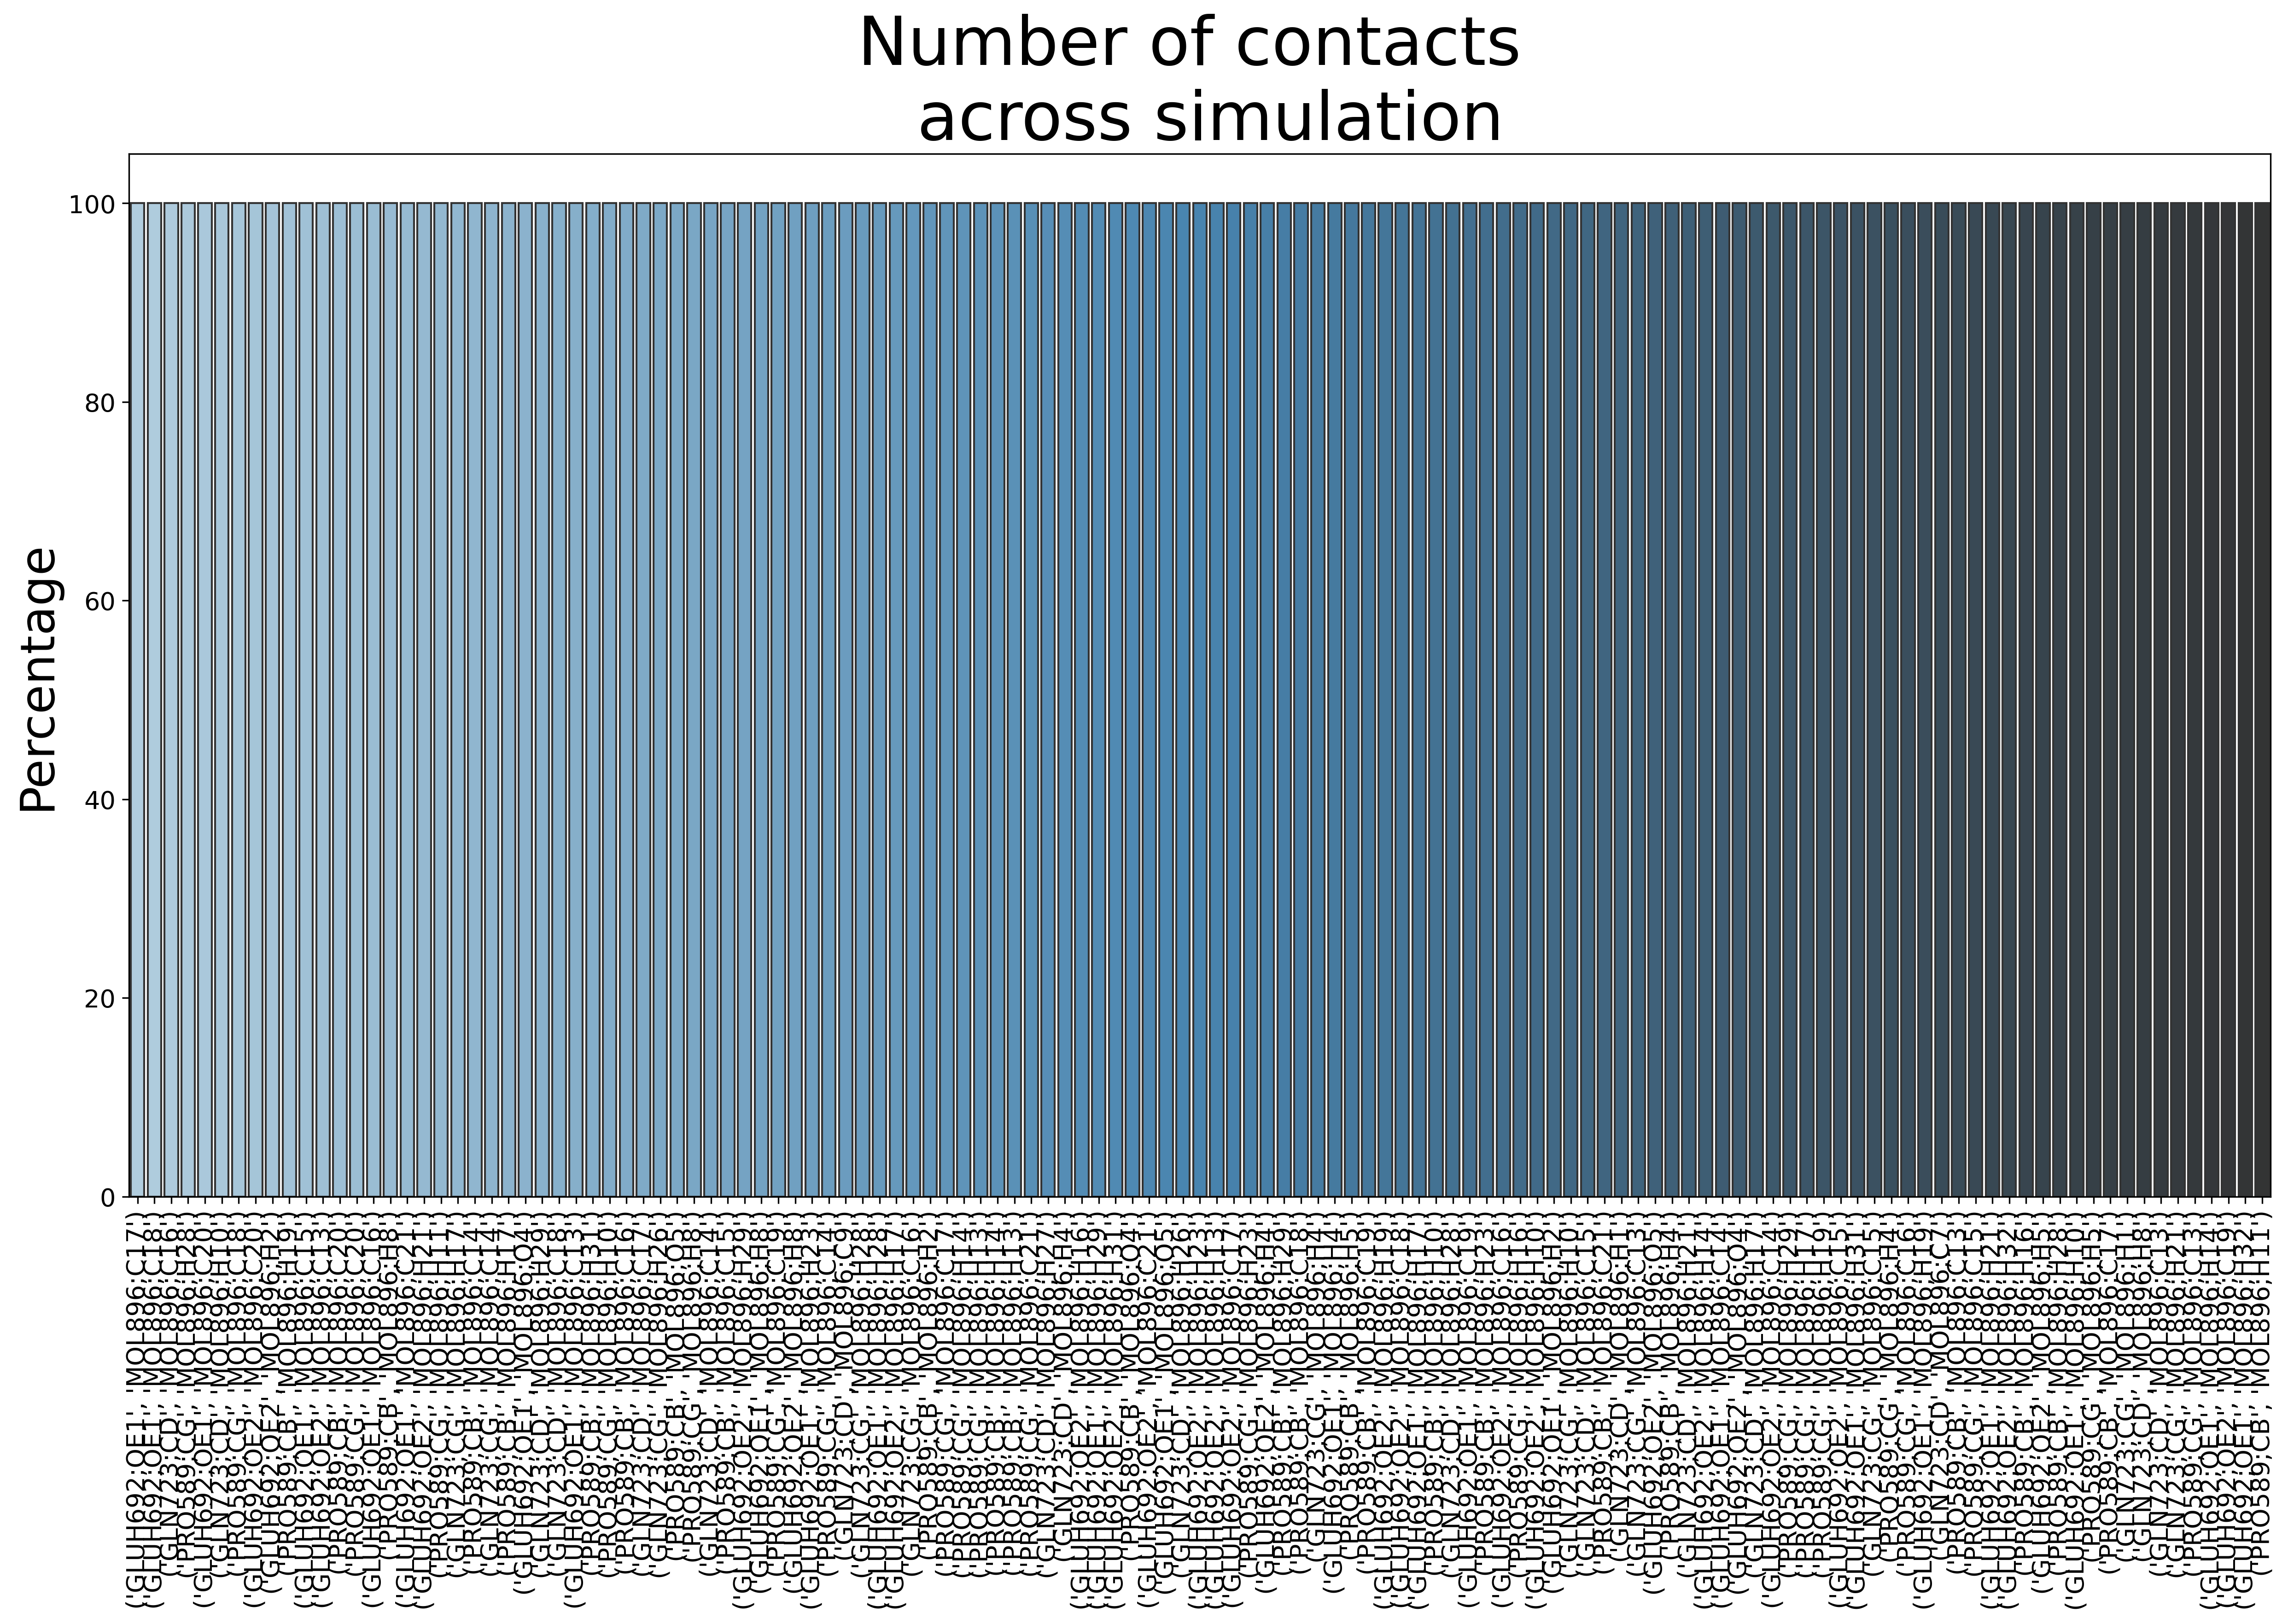

In [57]:
##Function to plot atom contacts across simulation
# to iterate over frames and obtain total contacts:
def plotear_atomos_conact(salida_contactos):
    """
    """
    pairs_freq=build_histogram(salida_contactos)
    df_freq=pd.DataFrame.from_dict(pairs_freq,orient='index',
                       columns=['Freq'])
    df_freq_sort=df_freq.sort_values(by='Freq',ascending=False)

##Normalizing data and plotting
    df_freq_sort.Freq=df_freq_sort.Freq/df_freq_sort.Freq.max()*100
    df_freq_sort=df_freq_sort[df_freq_sort["Freq"] > 20]

    fig = plt.figure(figsize=[20,10],dpi=300)
    fig=sns.barplot(y=df_freq_sort.Freq,x=df_freq_sort.index,palette='Blues_d',data=df_freq_sort,ci=None,edgecolor='.2')

    plt.tick_params(axis='both',which='both',labelsize=13)
    plt.xlabel("",fontsize=18)
    plt.ylabel("Percentage",fontsize=25)
    plt.title('Number of contacts \n across simulation',fontsize=35)
    plt.xticks(rotation=90)
    plt.show()

#plt.savefig('NumbContacts.png',dpi=300)
########################

plotear_atomos_conact(distancias)

In [58]:
##Counting contacts across simulation and plotting

def build_counts(lines):
    """
    """
    longitude = {}

    for frame in lines:
        longitude[lines.index(frame)]=len(frame)
    return(longitude)          


    for key in longitude:
      print(
           "{}: {}".format(key, longitude[key])   #$
      )

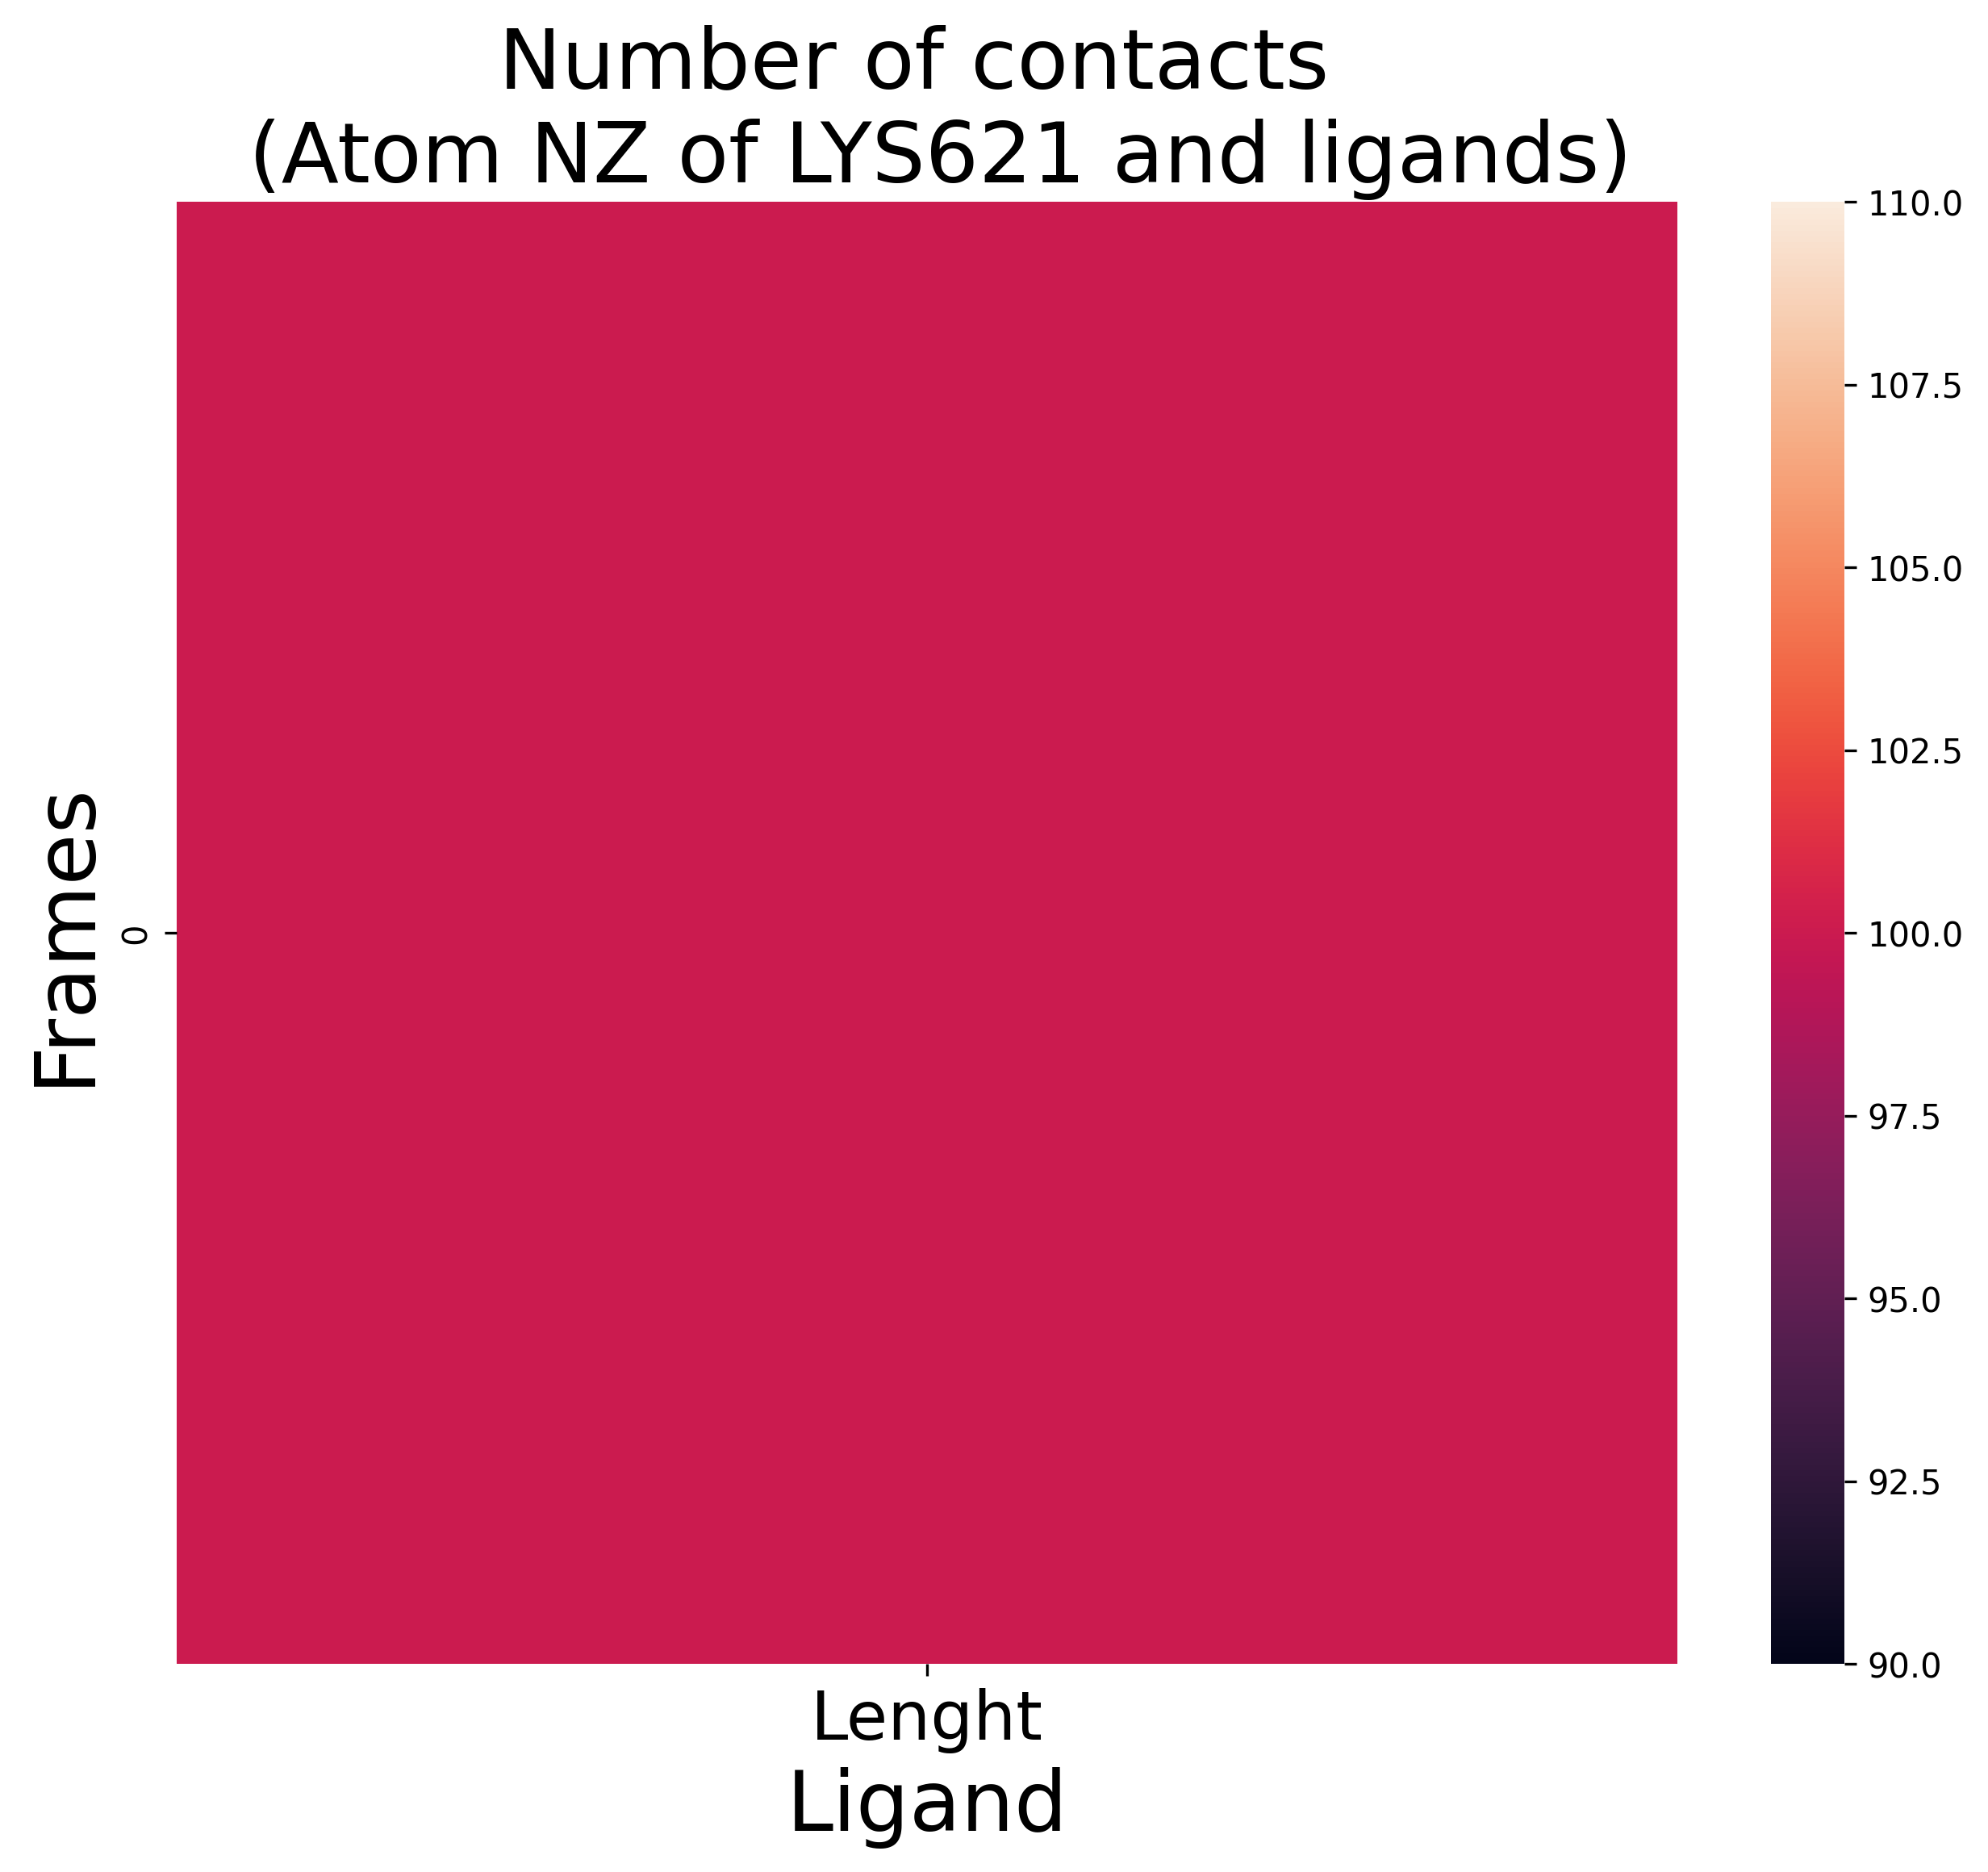

In [59]:
##Function to plot contacts across simulation
def plotear_contac(salida_contact):
    """
    """
    pairs_len=build_counts(salida_contact)
    df_len=pd.DataFrame.from_dict(pairs_len,orient='index',
                       columns=['Lenght'])

##Normalizing data
    df_len.Lenght=df_len.Lenght/df_len.Lenght.max()*100

    fig = plt.figure(figsize=[10,8],dpi=300)

    sns.heatmap(df_len)
    plt.tick_params(axis='x',which='both',labelsize=25)
    plt.ylabel("Frames",fontsize=25)
    plt.xlabel("Ligand",fontsize=25)
    plt.title('Number of contacts \n (Atom NZ of LYS621 and ligands)',fontsize=25)
    plt.tick_params(axis='x',labelsize=20)
    plt.tick_params(axis='y',labelsize=10)
    plt.show()

    #plt.savefig('NumbContacts.png',dpi=300)
########################

plotear_contac(frequencias)
